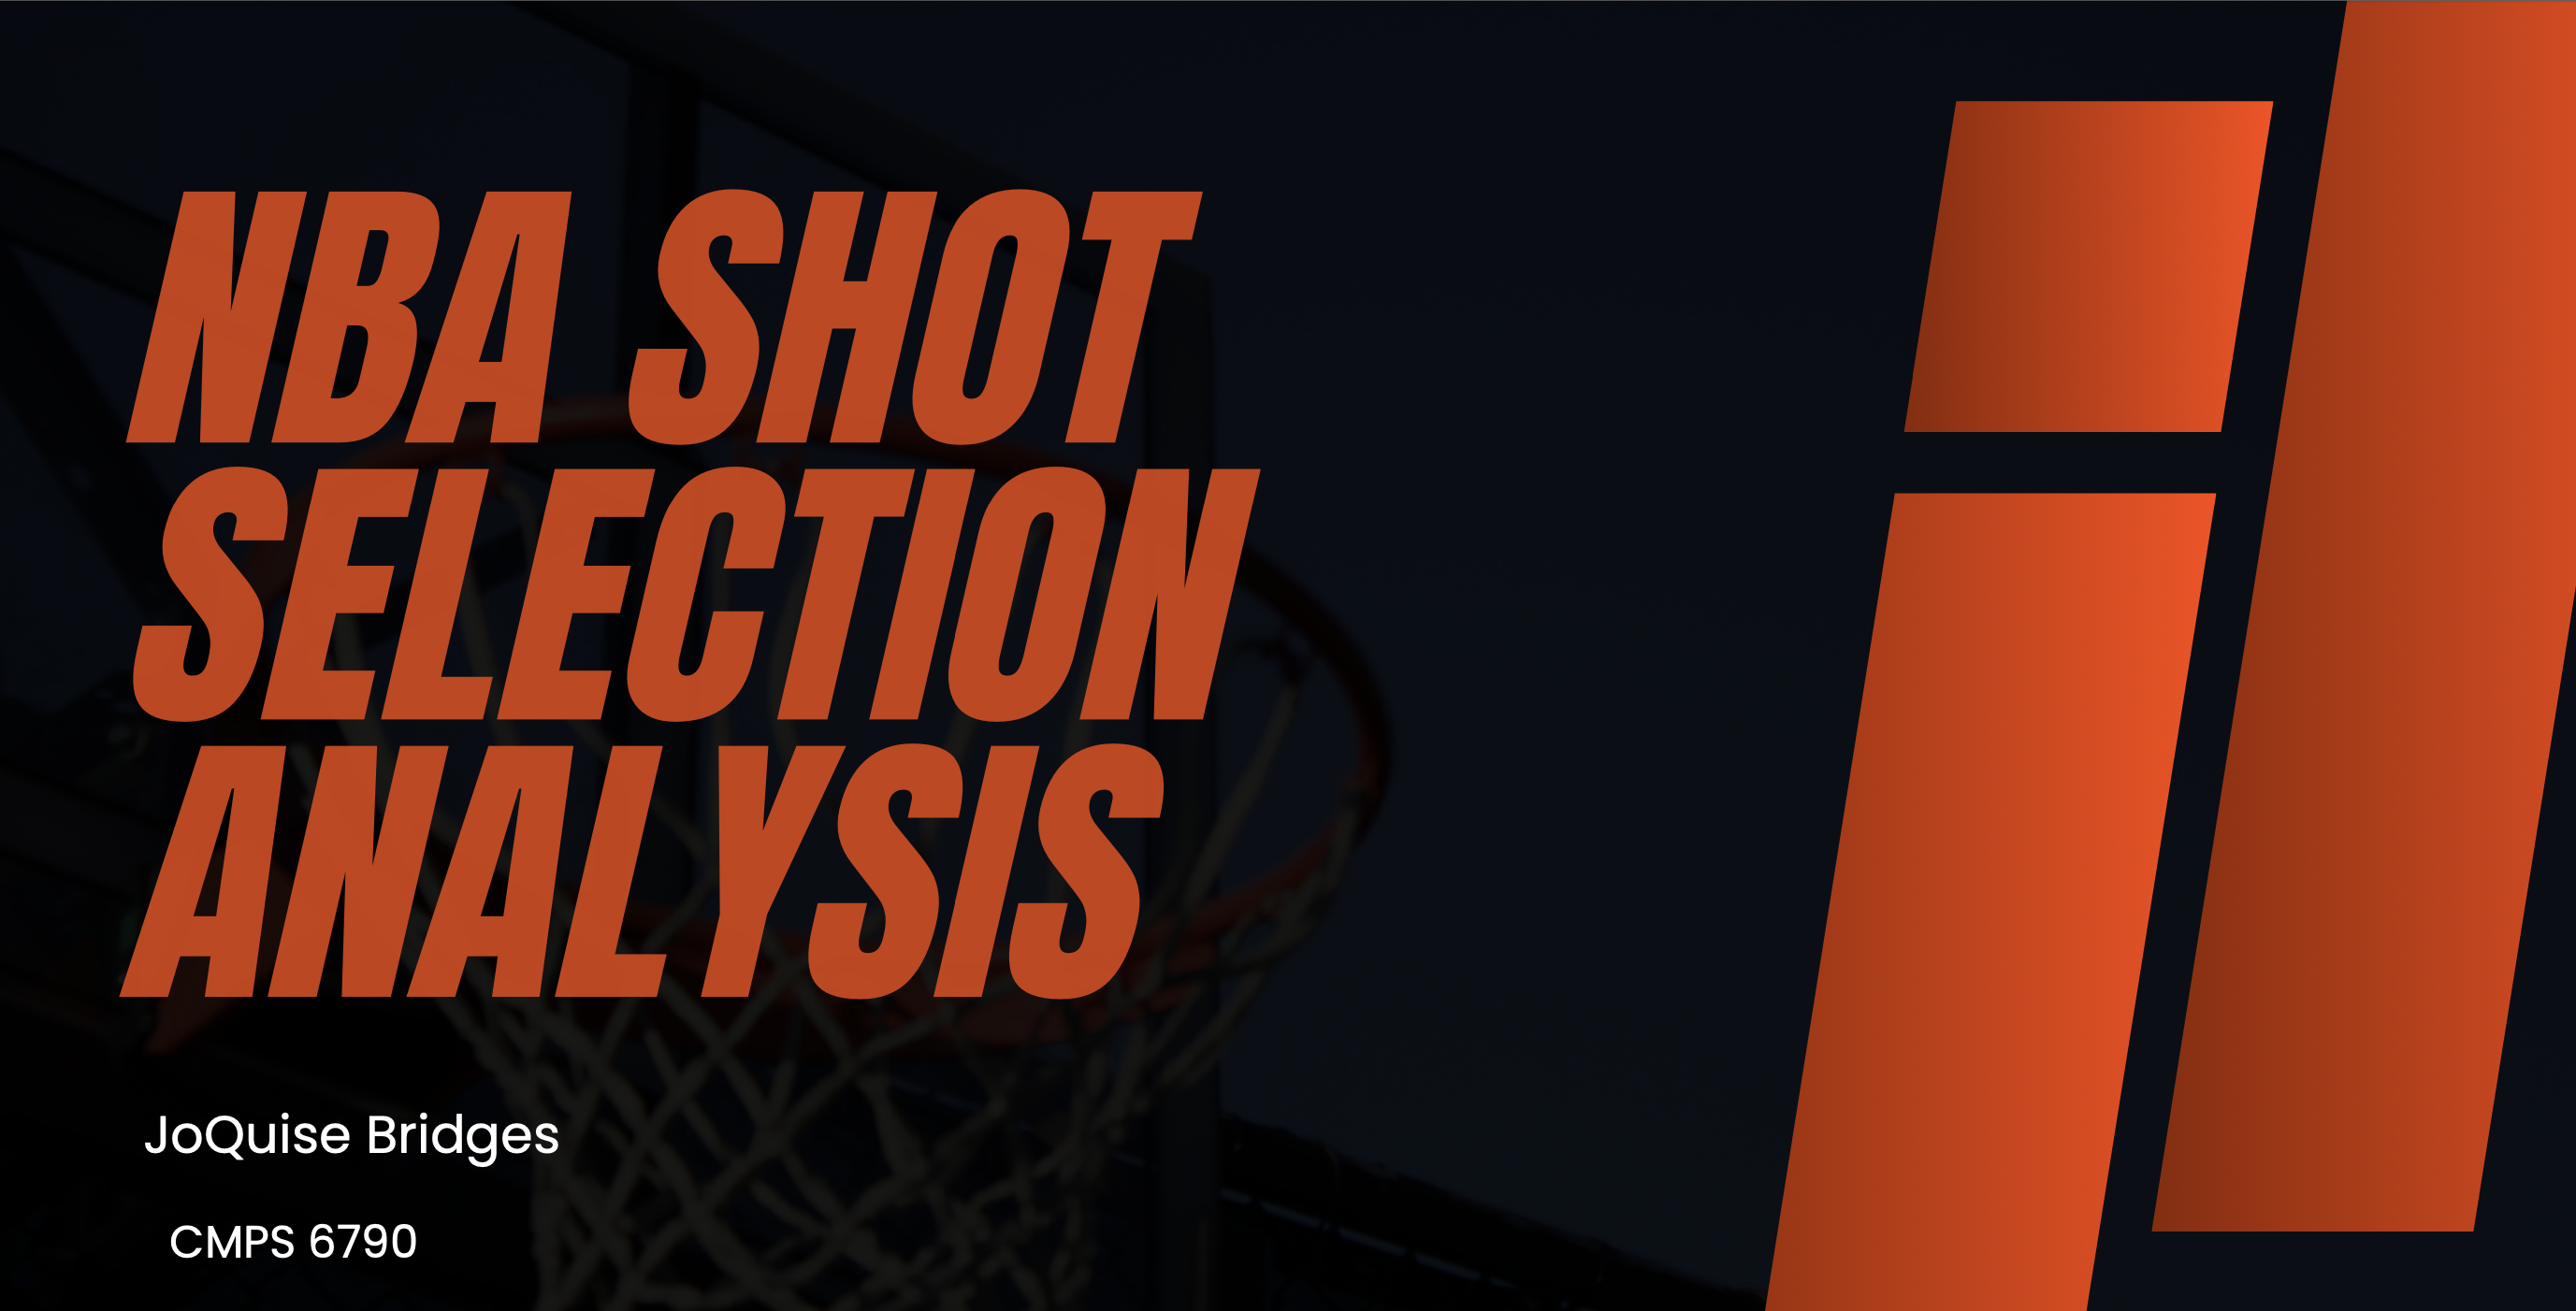

# NBA Shot Selection Analysis

## Final Tutorial Notebook

**By JoQuise Bridges**

**My Webpage:** [JoQuise's Github](https://github.com/bjoquise) 

**My Github Page:** [Link to Github.io](https://bjoquise.github.io)

### Outline:
1. Introduction
2. Data Extraction, Transform and Load (ETL)
3. Exploratory Data Analysis (EDA)
4. Hypothesis and Proposed Model
5. Conclusion

## 1: Introduction

Have you ever heard of a "clutch" player when involving basketball? What makes people say that Steph Curry or Lebron James are more clutch than Julius Randall or Naji Marshall? Is there a way we can predict in general if a person will make or miss a shot?

As I learned from [here](https://www.nba.com/news/stats-breakdown-coming-through-in-the-clutch), the clutch time as definined in the NBA as the final five minutes of the fourth quarter or overtime when the score is within five points. For this project, we will look at it a bit more plainly, but backed up statsitically.

The goal of this project/tutorial is to dive deeper into NBA shot selection data in order to gain insights on what factors play a role in(or any role) in if a player will make the shot. More specifically, we try to get a deeper understanding of the definition of a "clutch" shot and does it matter/exist.  

**Questions we seek to answer**:

1. Who was the clutchest team?

2. What is the best zone and/or position possible to make a clutch shot? Does the type of shot or the distance matter more into making it?

3. What is one of the main factors that affect whether a player will make or miss a clutch shot?


**Resources**:

1. A collection of every NBA shot attempted, by every player, from the 2003-04 season until the 2023-2024 season: [datasets here](https://www.kaggle.com/datasets/mexwell/nba-shots?resource=download)

2. NBA Clutch Shooting Breakdown from the 2023-2024 season for the top 50 players: [chart here](https://stats.inpredictable.com/nba/ssnPlayerSplit.php?season=2023&pos=ALL&team=ALL&po=0&frdt=2021-10-19&todt=2022-06-16&shot=both&dst=plyr)

## 2: Data Extraction, Transform and Load (ETL)

### Setup and Imports
First, we need to make sure to install and import everything needed for the project to function correctly:

In [1]:
# To satisfy requirements
!pip3 install lxml
!pip3 install html5lib

In [33]:
# DataFrames & Scrapping
import pandas as pd
import glob
import numpy as np
import requests
from bs4 import BeautifulSoup

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preoprosessing and Machine Learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

Just making sure we are in the correct file for extraction:

In [3]:
%cd /home/jovyan/notebooks/cmps6790/_labs/

/home/jovyan/notebooks/cmps6790/_labs


Since the Kaggle datasets are by year, I chose to use [glob](https://docs.python.org/3/library/glob.html), so that I can combine all of these files and then group the datasets into 3-year periods so that I can explore the changes over time while maintaining this huge amount of data.

In [4]:
info = []
all_year_shots = glob.glob("data/shots/*.csv")

# Extract year from filenames and sort files by year
file_info = []

for datafile in all_year_shots:
    year = int(datafile.split('NBA_')[1].split('_Shots.csv')[0])
    file_info.append((year, datafile))
    
file_info = sorted(file_info) 

I used `glob` to locate all of those csv files with the NBA shot data, then extracted the year to store it in that list `file_info` to set it up for the sorting within the next lines of code.

In [5]:
# Group files into 3-year periods
start_year = 2003
end_year = 2024
three_year_groups = []

while start_year < end_year:
    group_files = [file[1] for file in file_info if start_year <= file[0] < start_year + 3]
    three_year_groups.append((start_year, start_year + 2, group_files))
    start_year += 3
    
for i, (period_start, period_end, files) in enumerate(three_year_groups, start=1):
    list_of_frames = []
    for file in files:
        shots_df = pd.read_csv(file)
        list_of_frames.append(shots_df)
    combined_df = pd.concat(list_of_frames, ignore_index=True)
    
    var = f"p{i}_shots_df"
    globals()[var] = combined_df
    print(f"DataFrame: {var} for {period_start}-{period_end} with {len(combined_df)} rows.")

DataFrame: p1_shots_df for 2003-2005 with 387429 rows.
DataFrame: p2_shots_df for 2006-2008 with 590887 rows.
DataFrame: p3_shots_df for 2009-2011 with 599757 rows.
DataFrame: p4_shots_df for 2012-2014 with 566910 rows.
DataFrame: p5_shots_df for 2015-2017 with 623372 rows.
DataFrame: p6_shots_df for 2018-2020 with 619281 rows.
DataFrame: p7_shots_df for 2021-2023 with 624925 rows.


This is where I was able to group into the 3-year periods, reading them into dataframes, as well as concatenating them to create each period. I found info from [here](https://stackoverflow.com/questions/4277056/declaring-a-global-dynamic-variable-in-python) about how I could dynamically name the variables so the grouping can be far more simplified.

### Tidying

I began to drop the variables I felt were not needed for what I was analyzing. I chose to keep the `Team_ID`, for the teams that have changed their names, but are essentially the same team, such as New Orleans. I dropped the `SEASON_1` and `SEASON_2` since I already did the work to put the year as a variable.
I also dropped `POSITION_GROUP`, `ZONE_ABB`, `ZONE_RANGE`, since I felt they were accounted for within the dataset.

I combiuned the shot location data into a single tuple column, `LOCATION`, to simplify the coordinates in visualizations.
I chose to keep a lot of the variables because of the countless relationships I could compare and make connections out of but as the project funnels into the more important factors, I may drop more. I wanted to convert the data types to make sure that they are correct.

In [6]:
all_shots_dfs = [p1_shots_df, p2_shots_df, p3_shots_df, p4_shots_df, p5_shots_df, p6_shots_df, p7_shots_df]

for i, shots_df in enumerate(all_shots_dfs, start=1):
    shots_df = shots_df.drop(columns=['SEASON_1', 'SEASON_2', 'POSITION_GROUP', 'ZONE_ABB', 'ZONE_RANGE'], errors='ignore')
    
    shots_df['LOCATION'] = list(zip(shots_df['LOC_X'], shots_df['LOC_Y']))
    shots_df = shots_df.drop(columns=['LOC_X', 'LOC_Y'], errors='ignore')
    shots_df = shots_df.drop(columns=['EVENT_TYPE'], errors='ignore')
    
    shots_df['GAME_DATE'] = pd.to_datetime(shots_df['GAME_DATE'], errors='coerce')
    globals()[f"p{i}_shots_df"] = shots_df

In [7]:
p7_shots_df.head()

TEAM_ID           TEAM_NAME  PLAYER_ID   PLAYER_NAME POSITION  \
0  1610612753       Orlando Magic    1630175  Cole Anthony       PG   
1  1610612753       Orlando Magic    1630175  Cole Anthony       PG   
2  1610612755  Philadelphia 76ers    1630194     Paul Reed       PF   
3  1610612753       Orlando Magic    1630175  Cole Anthony       PG   
4  1610612742    Dallas Mavericks    1630189     Tyler Bey       SF   

   GAME_DATE   GAME_ID HOME_TEAM AWAY_TEAM  SHOT_MADE          ACTION_TYPE  \
0 2021-05-16  22001075       PHI       ORL      False            Jump Shot   
1 2021-05-16  22001075       PHI       ORL      False     Pullup Jump shot   
2 2021-05-16  22001075       PHI       ORL       True   Driving Layup Shot   
3 2021-05-16  22001075       PHI       ORL       True  Step Back Jump shot   
4 2021-05-16  22001071       MIN       DAL      False        Tip Dunk Shot   

        SHOT_TYPE         BASIC_ZONE          ZONE_NAME  SHOT_DISTANCE  \
0  3PT Field Goal      Left Corner 3          Left Side             23   
1  3PT Field Goal  Above the Break 3   Left Side Center             27   
2  2PT Field Goal    Restricted Area             Center              3   
3  3PT Field Goal  Above the Break 3  Right Side Center             26   
4  2PT Field Goal    Restricted Area             Center              0   

   QUARTER  MINS_LEFT  SECS_LEFT        LOCATION  
0        4          0         15  (-2.31, 5.995)  
1        4          0         20  (-1.75, 7.925)  
2        4          0         24  (-0.24, 5.965)  
3        4          0         41   (1.45, 7.975)  
4        4          0         25   (-0.0, 5.775)

In [8]:
p7_shots_df.dtypes

TEAM_ID                   int64
TEAM_NAME                object
PLAYER_ID                 int64
PLAYER_NAME              object
POSITION                 object
GAME_DATE        datetime64[ns]
GAME_ID                   int64
HOME_TEAM                object
AWAY_TEAM                object
SHOT_MADE                  bool
ACTION_TYPE              object
SHOT_TYPE                object
BASIC_ZONE               object
ZONE_NAME                object
SHOT_DISTANCE             int64
QUARTER                   int64
MINS_LEFT                 int64
SECS_LEFT                 int64
LOCATION                 object
dtype: object

**Second Dataset:** NBA Clutch Shooting Breakdown for 2023-2024 Season.

I wanted to grab this dataset since it was fairly recent with actual clutch NBA stats with some of the following columns:

`Cltch`: Shots with a notable win probability impact.
`Cltch2`: Shots in the top 1% of win probability impact.

In [9]:
r = requests.get('https://stats.inpredictable.com/nba/ssnPlayerSplit.php?season=2023&pos=ALL&team=ALL&po=0&frdt=2024-10-22&todt=2024-12-07&shot=both&dst=plyr', 
                 headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/7046A194A'})

In [10]:
soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find('table')

I was able to use the requests library to scrape NBA player clutch shooting data from the 2023–2024 season.That `User-Agent` request simulates a browser user agent to bypass potential scraping restrictions. After retrieving the content, BeautifulSoup is used to parse the HTML and extract tables.

In [11]:
df_tables = []
for t in soup.findAll("table"):
    df_t = pd.read_html(str(t))
    df_tables.append(df_t[0])
    
top50_df = df_tables[0]
top50_df.head(10)

/tmp/ipykernel_49732/130072415.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_t = pd.read_html(str(t))


Unnamed: 0_level_0  Unnamed: 1_level_0  Unnamed: 2_level_0  \
                  Rnk              Player                 Pos   
0  League Benchmarks:  League Benchmarks:  League Benchmarks:   
1                   1       DeMar DeRozan                 G-F   
2                   2        Kevin Durant                   F   
3                   3        De'Aaron Fox                   G   
4                   4          Coby White                   G   
5                   5        Tyrese Maxey                   G   
6                   6       Stephen Curry                   G   
7                   7        LeBron James                   F   
8                   8     Dejounte Murray                   G   
9                   9       Mikal Bridges                 G-F   

   Unnamed: 3_level_0  Unnamed: 4_level_0 All Field Goals (sortable)  \
                 Team                 Gms                       Grbg   
0  League Benchmarks:  League Benchmarks:         League Benchmarks:   
1                 CHI                  79                        144   
2                 PHX                  75                        220   
3                 SAC                  74                        278   
4                 CHI                  79                        140   
5                 PHI                  70                        182   
6                 GSW                  74                        165   
7                 LAL                  71                        192   
8                 ATL                  78                        203   
9                 BKN                  82                        188   

                                                               \
                 Nrml               Cltch              Cltch2   
0  League Benchmarks:  League Benchmarks:  League Benchmarks:   
1                1038                 147                  26   
2                1061                 138                  17   
3                1113                 136                  22   
4                 924                 132                  13   
5                1091                 132                  14   
6                1123                 128                  29   
7                 941                 125                  11   
8                1105                 124                  31   
9                 971                 115                  20   

  % of Player Shots                      Effective Field Goal %                \
               Grbg   Nrml  Cltch Cltch2                   Grbg   Nrml  Cltch   
0             15.5%  75.7%   7.9%   0.9%                  46.4%  46.6%  45.9%   
1             10.6%  76.6%  10.8%   1.9%                  54.5%  50.8%  48.3%   
2             15.3%  73.9%   9.6%   1.2%                  60.2%  59.1%  49.6%   
3             17.9%  71.9%   8.8%   1.4%                  47.3%  55.3%  51.1%   
4             11.6%  76.4%  10.9%   1.1%                  63.9%  51.9%  53.4%   
5             12.8%  76.9%   9.3%   1.0%                  53.8%  53.0%  47.3%   
6             11.4%  77.7%   8.9%   2.0%                  53.3%  57.6%  62.9%   
7             15.1%  74.2%   9.9%   0.9%                  61.7%  59.9%  56.0%   
8             13.9%  75.5%   8.5%   2.1%                  56.9%  52.7%  49.2%   
9             14.5%  75.0%   8.9%   1.5%                  52.4%  51.8%  53.9%   

          
  Cltch2  
0  37.5%  
1  42.3%  
2  41.2%  
3  50.0%  
4  46.2%  
5  35.7%  
6  44.8%  
7  63.6%  
8  43.5%  
9  55.0%

That `soup.findAll("table")` method identifies all tables within the HTML content, where then I read into pandas using `pd.read_html`, converting the HTML structure into a DataFrame.

To tidy, I flattened the multi-level column names by joining the hierarchical labels into a single level. [This](https://www.geeksforgeeks.org/how-to-flatten-a-hierarchical-index-in-pandas-dataframe-columns/) explains flattening a bit more. 

Then, I dropped the unnecessary percentage-based columns to focus on the absolute shot counts for different categories and made sure to rename the remaining.  

In [12]:
top50_df.columns = ['_'.join(col).strip() for col in top50_df.columns.values]
top50_df = top50_df.drop(columns=['% of Player Shots_Grbg',	'% of Player Shots_Nrml',	'% of Player Shots_Cltch',	'% of Player Shots_Cltch2',	'Effective Field Goal %_Grbg',
                                  'Effective Field Goal %_Nrml','Effective Field Goal %_Cltch',	'Effective Field Goal %_Cltch2'], errors='ignore')
top50_df.columns = [
    'RANK', 'PLAYER_NAME', 'POSITION', 'TEAM_NAME','GAMES_PLAYED', 'FIELD_GOALS_RBG', 'FIELD_GOALS_NORMAL','FIELD_GOALS_CLUTCH', 'FIELD_GOALS_CLUTCH_2']

top50_df = top50_df.iloc[1:].reset_index(drop=True)

top50_df.head(11)

RANK      PLAYER_NAME POSITION TEAM_NAME GAMES_PLAYED FIELD_GOALS_RBG  \
0     1    DeMar DeRozan      G-F       CHI           79             144   
1     2     Kevin Durant        F       PHX           75             220   
2     3     De'Aaron Fox        G       SAC           74             278   
3     4       Coby White        G       CHI           79             140   
4     5     Tyrese Maxey        G       PHI           70             182   
5     6    Stephen Curry        G       GSW           74             165   
6     7     LeBron James        F       LAL           71             192   
7     8  Dejounte Murray        G       ATL           78             203   
8     9    Mikal Bridges      G-F       BKN           82             188   
9    10      Paul George        F       LAC           74             193   
10   11    Jalen Brunson        G       NYK           76             241   

   FIELD_GOALS_NORMAL FIELD_GOALS_CLUTCH FIELD_GOALS_CLUTCH_2  
0                1038                147                   26  
1                1061                138                   17  
2                1113                136                   22  
3                 924                132                   13  
4                1091                132                   14  
5                1123                128                   29  
6                 941                125                   11  
7                1105                124                   31  
8                 971                115                   20  
9                 921                113                    9  
10               1276                111                   20

In [13]:
top50_df.dtypes

RANK                    object
PLAYER_NAME             object
POSITION                object
TEAM_NAME               object
GAMES_PLAYED            object
FIELD_GOALS_RBG         object
FIELD_GOALS_NORMAL      object
FIELD_GOALS_CLUTCH      object
FIELD_GOALS_CLUTCH_2    object
dtype: object

No way these can all be objects! So I went through and made sure to make the numeric ones integers, as well as downcasted to save memory.

In [14]:
top50_df['RANK'] = top50_df['RANK'].apply(pd.to_numeric, errors='coerce', downcast='integer')
top50_df['GAMES_PLAYED'] = top50_df['GAMES_PLAYED'].apply(pd.to_numeric, errors='coerce', downcast='integer')
top50_df['FIELD_GOALS_RBG'] = top50_df['FIELD_GOALS_RBG'].apply(pd.to_numeric, errors='coerce', downcast='integer')
top50_df['FIELD_GOALS_NORMAL'] = top50_df['FIELD_GOALS_NORMAL'].apply(pd.to_numeric, errors='coerce', downcast='integer')
top50_df['FIELD_GOALS_CLUTCH'] = top50_df['FIELD_GOALS_CLUTCH'].apply(pd.to_numeric, errors='coerce', downcast='integer')
top50_df['FIELD_GOALS_CLUTCH_2'] = top50_df['FIELD_GOALS_CLUTCH_2'].apply(pd.to_numeric, errors='coerce', downcast='integer')

top50_df.dtypes

RANK                      int8
PLAYER_NAME             object
POSITION                object
TEAM_NAME               object
GAMES_PLAYED              int8
FIELD_GOALS_RBG          int16
FIELD_GOALS_NORMAL       int16
FIELD_GOALS_CLUTCH       int16
FIELD_GOALS_CLUTCH_2      int8
dtype: object

## 3: Exploratory Data Analysis (EDA)

### EDA 1: Shot Success Rate vs the Shot Distance over the periods.

This graph should explore the relationship between shot success rate and shot distance across different periods. It addresses my second question by highlighting how shot distance affects success and whether patterns emerge over time.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

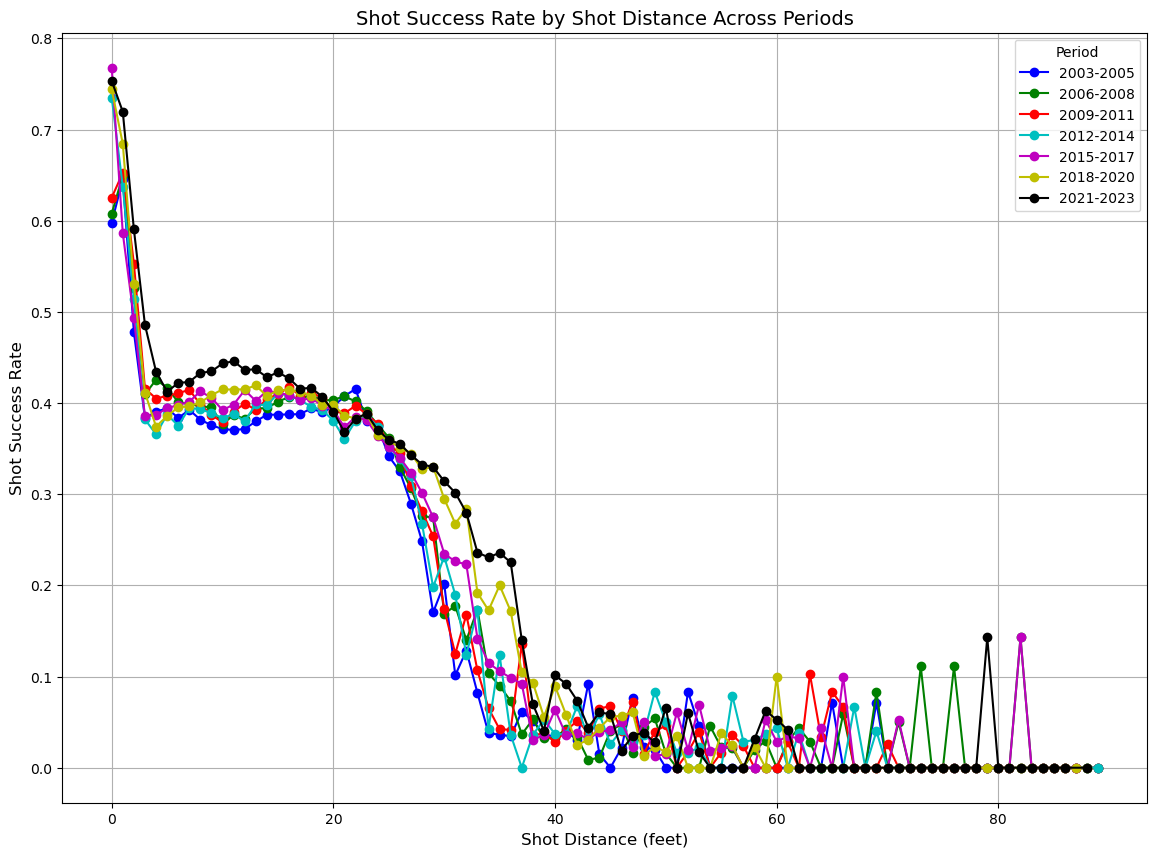

In [15]:
periods = [p1_shots_df, p2_shots_df, p3_shots_df, p4_shots_df, p5_shots_df, p6_shots_df, p7_shots_df]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
labels = ['2003-2005', '2006-2008', '2009-2011', '2012-2014', '2015-2017', '2018-2020', '2021-2023']

plt.figure(figsize=(14, 10))
for i, period in enumerate(periods):
    distance_success = period.groupby('SHOT_DISTANCE')['SHOT_MADE'].mean().reset_index()
    plt.plot(distance_success['SHOT_DISTANCE'], distance_success['SHOT_MADE'], 
             label=labels[i], color=colors[i], marker='o')
    
plt.title("Shot Success Rate by Shot Distance Across Periods", fontsize=14)
plt.xlabel("Shot Distance (feet)", fontsize=12)
plt.ylabel("Shot Success Rate", fontsize=12)
plt.legend(title="Period")
plt.grid()
plt

**Analysis**:As expected, close-range shots (0–10 feet) have the highest success rate, consistently peaking across all periods. The success rate drops significantly for mid-range and long-range shots, particularly beyond 25 feet, with noticeable noise for extremely long distances. Over time though, it appears that more people were successful in making some very long range shots, as well as the later periods the confidence must be high from around 2015 forward where they seem to have a higher success rate from further. Let's try to examine deeper.

In [16]:
period_list = {"2003-2005": p1_shots_df, "2006-2008": p2_shots_df, "2009-2011": p3_shots_df, "2012-2014": p4_shots_df, "2015-2017": p5_shots_df,
    "2018-2020": p6_shots_df, "2021-2023": p7_shots_df,}

stats = []
for period, df in period_list.items():
    mean_dist = df['SHOT_DISTANCE'].mean()
    median_dist = df['SHOT_DISTANCE'].median()
    std_dist = df['SHOT_DISTANCE'].std()
    
    stats.append({
        "Period": period,
        "Mean Shot Distance": mean_dist,
        "Median Shot Distance": median_dist,
        "Standard Deviation": std_dist })

stats_df = pd.DataFrame(stats)
stats_df.head(7)

Period  Mean Shot Distance  Median Shot Distance  Standard Deviation
0  2003-2005           11.671524                  13.0            9.615730
1  2006-2008           11.921892                  13.0            9.887182
2  2009-2011           11.998678                  13.0            9.856919
3  2012-2014           12.182697                  12.0            9.755952
4  2015-2017           12.560911                  13.0           10.050685
5  2018-2020           13.199614                  13.0           10.535822
6  2021-2023           13.627275                  13.0           10.557339

**Analysis:** As expected, the mean shot distance has steadily increased over the years, rising from 11.67 feet in 2003–2005 to 13.63 feet in 2021–2023. This trend suggests a gradual shift in player strategies, possibly reflecting the growing emphasis on long-range shooting. I did notice that the standard deviation has remained relatively stable, suggesting that the variability in shot distances has not changed drastically over time, even as the players increasingly attempted longer shots.

### EDA 2: Team shot success rates over the periods

The goal for this analysis is to observe trends and variations among teams to understand their shooting consistency and improvement over the years. By visualizing the data, I aimed to identify which teams consistently perform well and how their shot success rates fluctuate across the different periods.

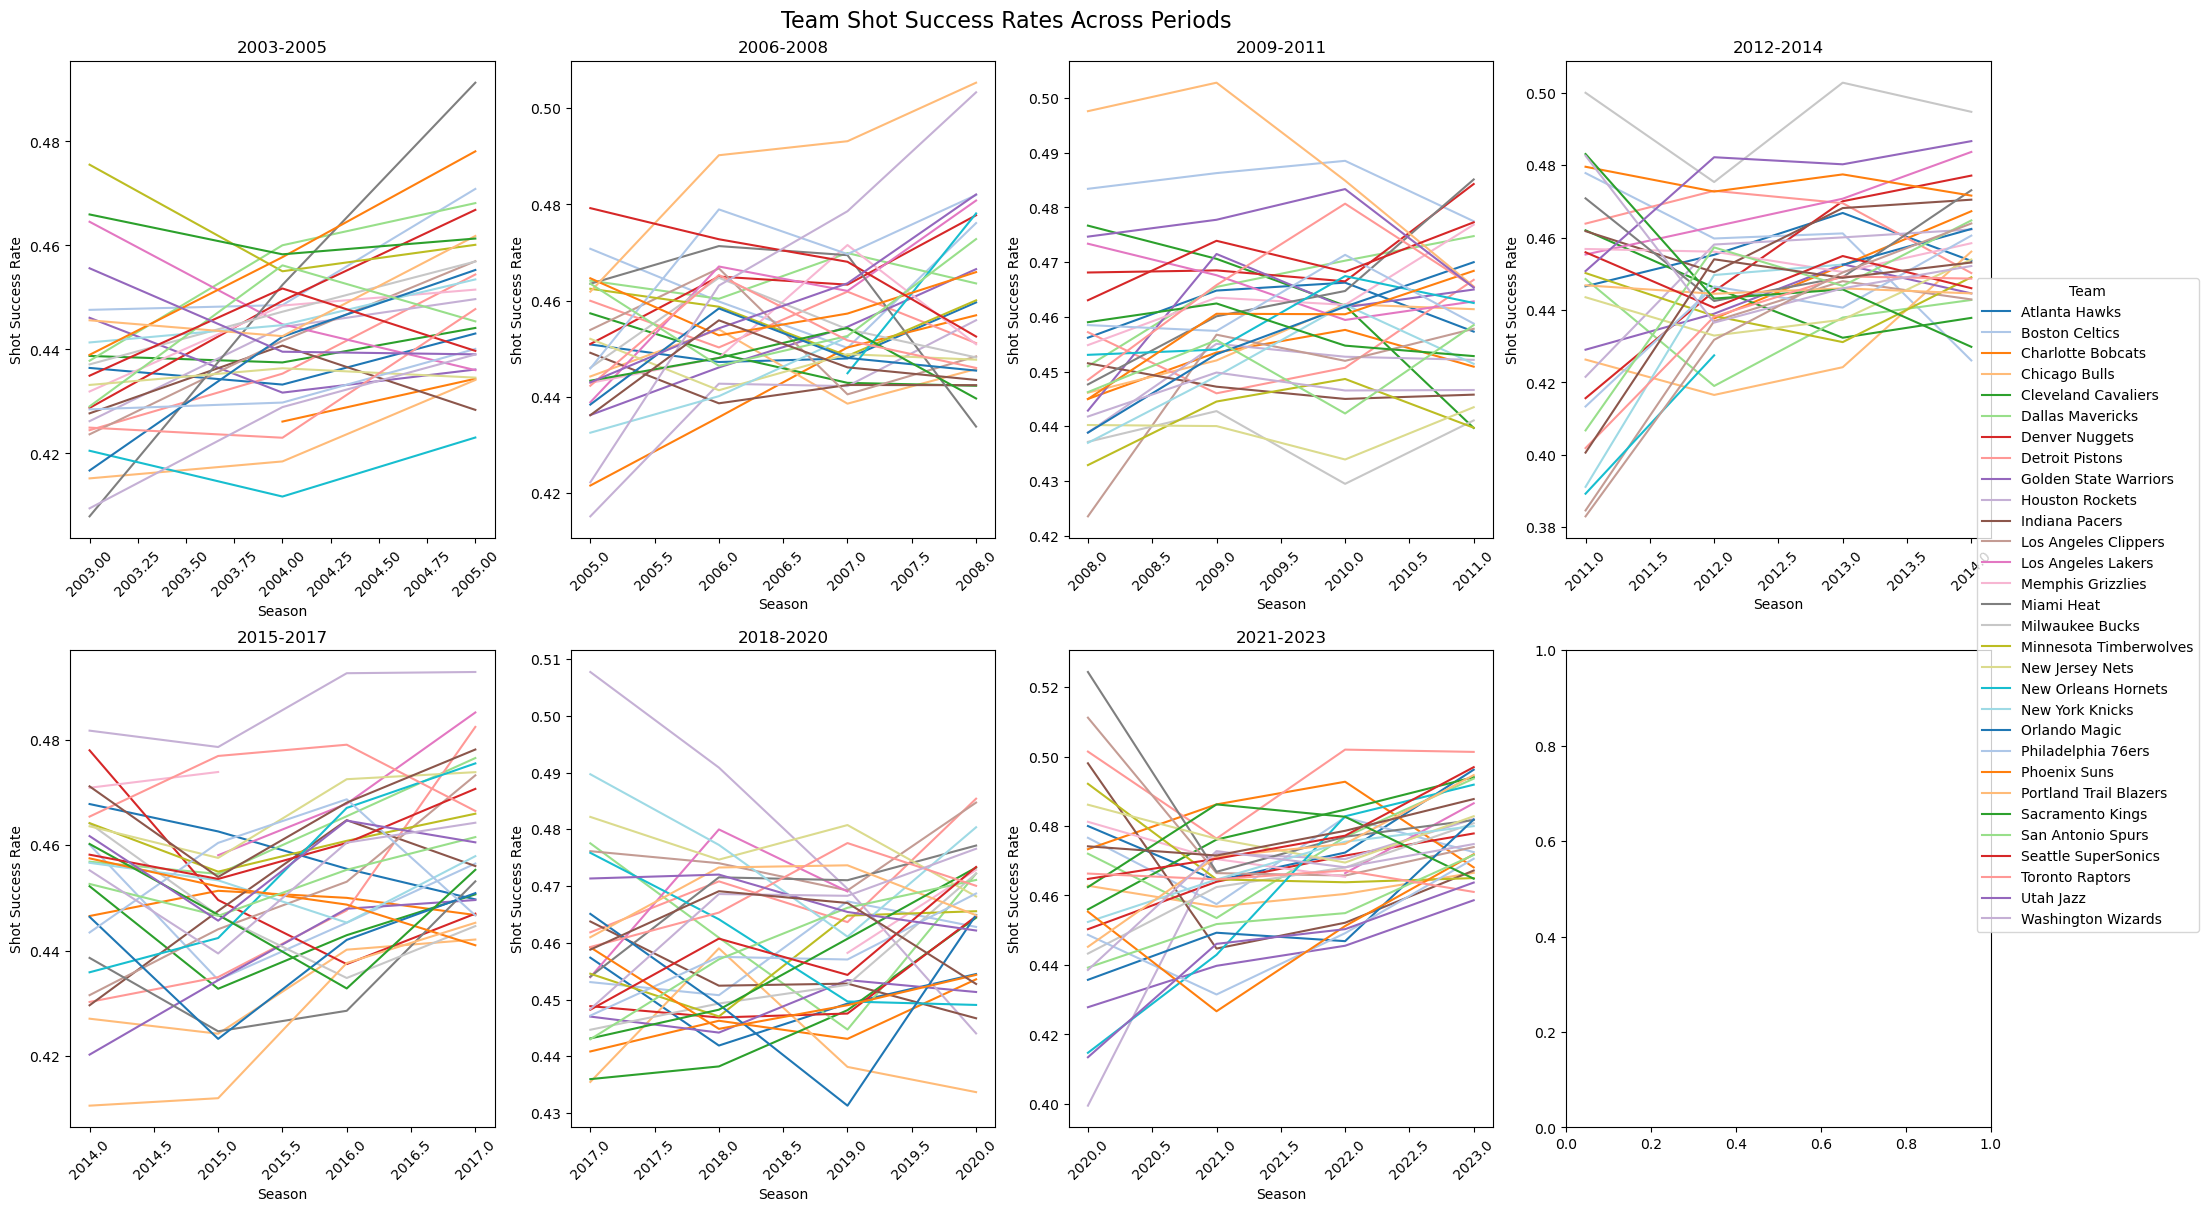

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), constrained_layout=True)
axes = axes.flatten()

for i, period in enumerate(periods):
    team_success = (period.groupby([period['TEAM_NAME'], period['GAME_DATE'].dt.year])['SHOT_MADE'].mean().reset_index())
    team_success.columns = ['TEAM_NAME', 'Season', 'SHOT_SUCCESS_RATE']
    
    sns.lineplot(data=team_success, x='Season', y='SHOT_SUCCESS_RATE', hue='TEAM_NAME', ax=axes[i], palette='tab20')
    axes[i].set_title(labels[i])
    axes[i].set_xlabel("Season")
    axes[i].set_ylabel("Shot Success Rate")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend([], [], frameon=False)  

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Team", loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.suptitle("Team Shot Success Rates Across Periods", fontsize=16)
plt.show()

**Analysis:** Code-wise, I grouped the data by team and year to calculate the mean shot success rate for each team per season, then plotted these rates, assiging each team a different color. Some teams, such as the Golden State Warriors (of course), display consistently high shot success rates over the years, reflecting their strong shooting efficiency. This reflects their fairly older roster that did a lot of dunking and close to the basket shots, until the 2015 and onward Warriors.

Meanwhile, teams like the Atlanta Hawks exhibit more fluctuation, with noticeable dips and rises in success rates. The 2018-2020 period shows increased clustering around higher success rates, potentially indicative of league-wide shooting improvements during this time.

### EDA 3: Which team(s) was/were the "clutchest"?

A very broad question but with this analysis I was attempting to answer the first question I thought of when creating this project. Once again, I defined clutch situations as shots taken with less than 3 minutes remaining in the game and during the 4th quarter or overtime. 

I felt that this analysis addresses the question of determining "clutchness" by narrowing the focus on teams that consistently excelled under high-pressure circumstances within these different periods.

In [19]:
team_success = {}
labels = ['2003-2005', '2006-2008', '2009-2011', '2012-2014', '2015-2017', '2018-2020', '2021-2023']
for i, period in enumerate(periods):
    clutch_shots = period[(period['MINS_LEFT'] < 3) & (period['QUARTER'] >= 4)]
    success_rate = clutch_shots.groupby('TEAM_NAME')['SHOT_MADE'].mean().sort_values(ascending=False)
    
    team_success[labels[i]] = success_rate

for label, success_rate in team_success.items():
    print(f"Top teams in {label}:\n{success_rate.head()}\n")

Top teams in 2003-2005:
TEAM_NAME
Memphis Grizzlies         0.453714
Houston Rockets           0.450279
Minnesota Timberwolves    0.440230
San Antonio Spurs         0.438323
Los Angeles Clippers      0.434426
Name: SHOT_MADE, dtype: float64

Top teams in 2006-2008:
TEAM_NAME
New Orleans/Oklahoma City Hornets    0.456616
San Antonio Spurs                    0.449029
Atlanta Hawks                        0.446948
Memphis Grizzlies                    0.446671
Boston Celtics                       0.442919
Name: SHOT_MADE, dtype: float64

Top teams in 2009-2011:
TEAM_NAME
Phoenix Suns           0.455072
Atlanta Hawks          0.454683
New Orleans Hornets    0.443874
Denver Nuggets         0.442249
Charlotte Bobcats      0.441895
Name: SHOT_MADE, dtype: float64

Top teams in 2012-2014:
TEAM_NAME
San Antonio Spurs       0.473520
Atlanta Hawks           0.455715
Miami Heat              0.455144
New Orleans Pelicans    0.441767
Los Angeles Lakers      0.439100
Name: SHOT_MADE, dtype: float64

To

**Analysis:** I found this one fairly useful until I got to the last period. The San Antonio Spurs, Atlanta Hawks, and LA Clippers, appear consistently across multiple periods, indicating a sustained ability to deliver under pressure. The Golden State Warriors emerge as top performers during the 2015–2017 and 2021–2023 periods, aligning with their championship runs. 

The issue arrives where the Washington Wizards in the latest period (2021–2023), performed well in clutch situations despite not being among the most successful franchises overall. This is the purest definition of [garbage time](https://en.wikipedia.org/wiki/Garbage_time), where it is the period toward the end of a timed sports competition that has become a blowout and the outcome has effectively already been decided. The Wizards were so horrible during that time, they made the highest percentage of shots within that time frame, because the game was determined and the other team stopped defending.

### EDA 4: What position has the highest cluch shot success?

I wanted to create this plot to recognize the importance of position with the clutch shot disribution, as well as the top 50 from the 2023 season to see what positon that they played in relation. The goal is to identify which positions contribute most to clutch shots and how this distribution has evolved over time.

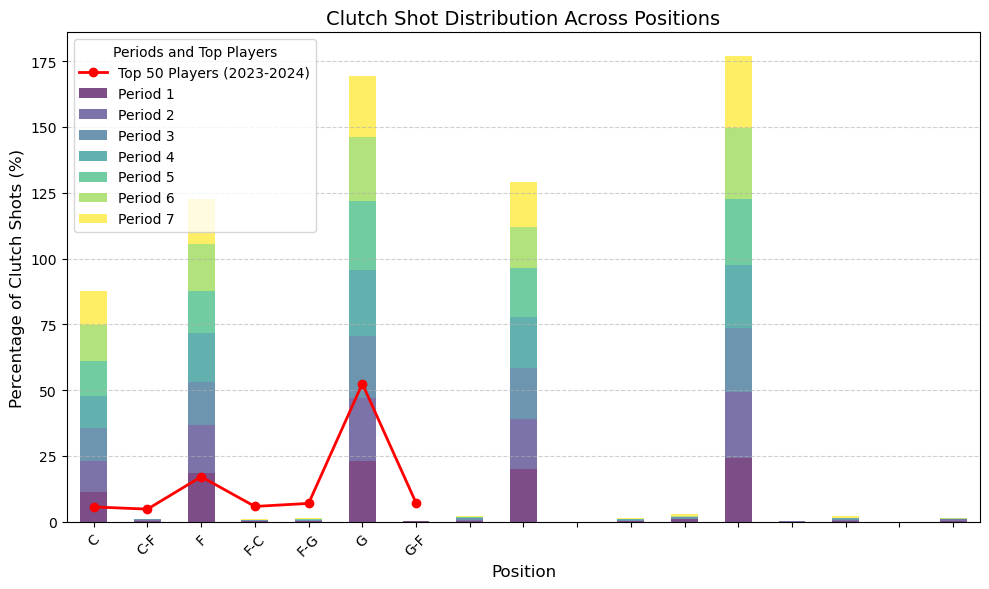

In [20]:
position_distribution = {}
for i, period_df in enumerate([p1_shots_df, p2_shots_df, p3_shots_df, p4_shots_df, p5_shots_df, p6_shots_df, p7_shots_df]):
    clutch_shots = period_df[(period_df['MINS_LEFT'] < 3) & (period_df['QUARTER'] >= 4)]
    position_counts = clutch_shots['POSITION'].value_counts(normalize=True) * 100
    position_distribution[f'Period {i+1}'] = position_counts

position_dist_df = pd.DataFrame(position_distribution).fillna(0)
top50_position_dist = top50_df.groupby('POSITION')['FIELD_GOALS_CLUTCH'].sum()
top50_position_dist /= top50_position_dist.sum()
top50_position_dist *= 100

fig, ax = plt.subplots(figsize=(10, 6))
position_dist_df.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', alpha=0.7)
top50_position_dist.plot(kind='line', marker='o', color='red', linewidth=2, ax=ax, label='Top 50 Players (2023-2024)')
plt.title('Clutch Shot Distribution Across Positions', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Percentage of Clutch Shots (%)', fontsize=12)
plt.legend(title='Periods and Top Players', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

**Analysis**: Not surprising but the bar chart reveals that the guard (G) position consistently dominates the distribution of clutch shots, contributing the highest percentage across all periods. Forwards (F) and center-forwards (F-C) follow, while center (C) players contribute significantly less. The red line for the top players suggests a strong consistency with the overall trends, reinforcing the dominance of specific positions in clutch situations.

## 4: Hypothesis and Proposed Model

#### Proposed Hypothesis: Can we predict whether a player will make or miss a clutch shot based on their shot attributes during critical game moments? Also, does the predictive power of these attributes vary across historical NBA periods?


My objective is to predict whether a shot is made based on analyzing the factors contributing to shot success in clutch moments across different NBA periods. The ***prediction value*** would be `SHOT_MADE` = True/False.

The features used/observed would be:

Player-Level Features: `PLAYER_NAME`, `TEAM_NAME`
Game-Time Features: `MINS_LEFT`, `SECS_LEFT`, `QUARTER`
Shot Features: `LOCATION`, `SHOT_DISTANCE`, `SHOT_TYPE`, `ACTION_TYPE`, `BASIC_ZONE`, `ZONE_NAME`
Outcome Feature: `SHOT_MADE

For the model, the goal is to use the clutch shots (`MINS_LEFT` < `3`, `QUARTER` >= `4`) from each of the seven periods, to identify factors contributing to success in clutch moments. I plan to do this by training a classification mode to analyze feature importance, Evaluate the predictive accuracy of shot success across different game periods, and compare periods (2003–2023) to find the highest-performing models.

First, I prepare the datasets for the machine learning by splitting the features into categorical and numerical groups. As we learned in class about one-hot encoding, I had to use it here preparation of the model or models.

In [21]:
features = ['TEAM_ID', 'PLAYER_NAME', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'BASIC_ZONE']
target = 'SHOT_MADE'
categorical_features = ['PLAYER_NAME', 'BASIC_ZONE']
numeric_features = ['SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT']

# Preprocessing
preprocessor = ColumnTransformer(transformers=[('num', 'passthrough', numeric_features),('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

Next, the most difficult part for my computer, was to figure out the pipeline, which I learned from [here](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html), to chain the preprocessing and model training steps, as well as figuring out the right hyperameters for grid search.

In [22]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])

param_grid = {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5], 'classifier__min_samples_leaf': [1, 2]}

The next block I did not want to split up too much, since a lot of it lived in a big for loop since I have 7 dataframes to run this on. The code loops through, filtering the data to include only "clutch shots" section, as it trains the Random Forest model using the clutch data for each time period. 

I used GridSearchCV to find the best hyperparameters, evaluates the model on a test set, and calculates metrics like accuracy and ROC AUC to assess performance. It takes a minute but it was worth it to find which period best fit the model.

In [23]:
all_shots_dfs = [p1_shots_df, p2_shots_df, p3_shots_df, p4_shots_df, p5_shots_df, p6_shots_df, p7_shots_df]
results = []

for i, shots_df in enumerate(all_shots_dfs, start=1):
    print(f"Analyzing period: {2003 + (i - 1) * 3}-{2005 + (i - 1) * 3}")
    
    shots_df['CLUTCH_TIME'] = ((shots_df['MINS_LEFT'] < 3) & (shots_df['QUARTER'] >= 4)).astype(int)
    clutch_df = shots_df[shots_df['CLUTCH_TIME'] == 1]
    if clutch_df.shape[0] < 50:
        print(f"Skipping period {i} due to insufficient clutch data.")
        continue

    X = clutch_df[features]
    y = clutch_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results.append({'Period': f"{2003 + (i - 1) * 3}-{2005 + (i - 1) * 3}", 'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Best Params': grid_search.best_params_})
    
    print(f"Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

Analyzing period: 2003-2005
Accuracy: 0.6501, ROC AUC: 0.6392
              precision    recall  f1-score   support

       False       0.67      0.81      0.73      4803
        True       0.61      0.42      0.49      3330

    accuracy                           0.65      8133
   macro avg       0.64      0.61      0.61      8133
weighted avg       0.64      0.65      0.63      8133

Analyzing period: 2006-2008
Accuracy: 0.6359, ROC AUC: 0.6383
              precision    recall  f1-score   support

       False       0.65      0.79      0.71      7141
        True       0.60      0.42      0.50      5318

    accuracy                           0.64     12459
   macro avg       0.63      0.61      0.61     12459
weighted avg       0.63      0.64      0.62     12459

Analyzing period: 2009-2011
Accuracy: 0.6400, ROC AUC: 0.6446
              precision    recall  f1-score   support

       False       0.65      0.80      0.72      7116
        True       0.62      0.43      0.51      54

In [ ]:
For easier comparison, I created a quick plot.

Summary of Model Performance Across Periods:


Period  Accuracy   ROC AUC  \
0  2003-2005  0.650068  0.639199   
1  2006-2008  0.635926  0.638289   
2  2009-2011  0.640045  0.644647   
3  2012-2014  0.648426  0.648643   
4  2015-2017  0.648300  0.654989   
5  2018-2020  0.656634  0.665878   
6  2021-2023  0.659413  0.667581   

                                         Best Params  
0  {'classifier__max_depth': 10, 'classifier__min...  
1  {'classifier__max_depth': 10, 'classifier__min...  
2  {'classifier__max_depth': 10, 'classifier__min...  
3  {'classifier__max_depth': 10, 'classifier__min...  
4  {'classifier__max_depth': 10, 'classifier__min...  
5  {'classifier__max_depth': 10, 'classifier__min...  
6  {'classifier__max_depth': 10, 'classifier__min...

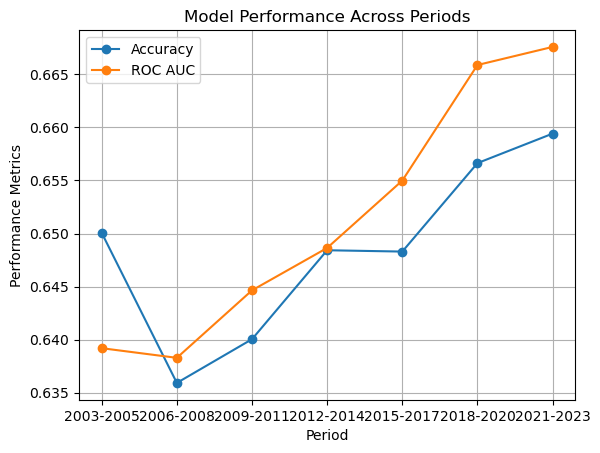

In [24]:
results_df = pd.DataFrame(results)

print("Summary of Model Performance Across Periods:")
display(results_df)
plt.plot(results_df['Period'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['Period'], results_df['ROC AUC'], label='ROC AUC', marker='o')
plt.xlabel("Period")
plt.ylabel("Performance Metrics")
plt.title("Model Performance Across Periods")
plt.legend()
plt.grid(True)

plt.show()

**Analysis:** Accuracy and ROC AUC demonstrate a slight upward trend over time, suggesting that the model's ability to predict whether a shot is made during clutch situations has gradually improved. I believe that it reflects the model's improved power in distinguishing between made and missed shots. Especially in the latest 2021-2023 period.

In terms of detailed performance, the classification reports for each period show that while the model performs well in predicting missed shots (higher precision and recall for the "False" class), it struggles with accurately identifying made shots (lower precision and recall for the "True" class). To dive deeper into this, I chose to only move forward with the best accuracy rate, which was in the 2021-2023 period, at 0.6594 and ROC AUC at 0.6676.

#### Further Investigation

Since we know that the best trained period is the last one, we can create a confusion matrix to add more visualization of the classification performace of the model, showing the true postives, true negatives, etc.

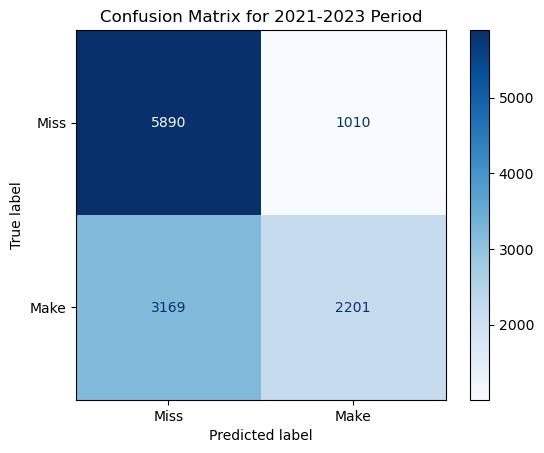

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Miss', 'Make'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for 2021-2023 Period')
plt.show()

This highlights the classification performance of the Random Forest model by showing that it predicted 2201 successful shots ("Make") correctly out of 5370 actual successful attempts, and 5890 missed shots correctly out of 6900 total missed shots. However, there are 1010 false positives (shots predicted as successful but missed) and 3169 false negatives (shots predicted as missed but were actually successful). This indicates that the model is more accurate in identifying missed shots but struggles with accurately predicting successful shots. 

In [38]:
rf_classifier = best_model.named_steps['classifier']

preprocessor = best_model.named_steps['preprocessor']
processed_feature_names = preprocessor.transformers_[0][2] + \
    list(preprocessor.transformers_[1][1].get_feature_names_out())
important_features = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': rf_classifier.feature_importances_}).sort_values(by='Importance', ascending=False)

print("Top Features to Focus on for Improvement:")
display(important_features.head(10))

Top Features to Focus on for Improvement:


Feature  Importance
0                       SHOT_DISTANCE    0.219509
760        BASIC_ZONE_Restricted Area    0.218919
755      BASIC_ZONE_Above the Break 3    0.133367
3                           SECS_LEFT    0.057545
759              BASIC_ZONE_Mid-Range    0.043454
2                           MINS_LEFT    0.022865
757  BASIC_ZONE_In The Paint (Non-RA)    0.022616
761         BASIC_ZONE_Right Corner 3    0.019497
758          BASIC_ZONE_Left Corner 3    0.015254
756              BASIC_ZONE_Backcourt    0.013501

### 5: Conclusion

My project explored the concept of "clutch" performance in basketball, delving into whether it is possible to predict if a player will make or miss a clutch shot using statistical and machine learning techniques. The analysis revealed that certain factors, such as `SHOT_DISTANCE` and `BASIC_ZONE_Restricted Area`, consistently emerge as the most significant predictors of success in clutch situations. 

Interestingly, zones close to the basket and specific shot distances carry the highest importance, which aligns with my intuition that closer, high-percentage areas are more reliable in high-pressure situations. However, secondary factors like `SECS_LEFT` and `MINS_LEFT`, indicative of the dwindling game clock, also play a nuanced role, underscoring the psychological and situational dynamics that shape shot outcomes. It would appear that "clutch" is mostly a stat for the eyeballs.

Circling back to the broader goals of my study, these results suggest that a "clutch" player or team is defined not just by skill or zone preferences but by their ability to maximize performance in high-stakes contexts. Future work could expand upon this analysis by incorporating player-specific psychological data or game context metrics, such as defensive pressure, to provide a richer understanding of clutch performance, mainly win percentages as well. Ultimately, this study bridges statistical insights with the normal basketball phenomena, opening avenues for deeper exploration of what it means to succeed under pressure. Thank you!